# Principal Component Analysis

# Required Packages

In [4]:
using Pkg
Pkg.add(["BenchmarkTools",
        "CSV",
        "DataFrames",
        "Distributed",
        "Flux",
        "LinearAlgebra",
        "MultivariateStats",
        "Plots",
        "PlotThemes",
        "ProgressBars",
        "PyCall",
        "ScikitLearn",
        "Statistics"])

  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]


# Loading Data

Loads dataset into dataframe before one-hot encoding categorical features

In [5]:
using CSV, DataFrames, LinearAlgebra, ProgressBars
using Flux: onehotbatch

In [6]:

# Loading CSV into dataframe
df = DataFrame(CSV.read("01_hdp.csv"))

# Getting dimensions of 
r, c = size(df)
println("dimensions of df: " * string((r, c)))

println("df head:")
println(first(df))
println()

# Getting column names
df_cols = names(df)
println("Columns:")
println(df_cols)

# Getting column types
df_cols_types = eltype.(eachcol(df))
println("Column data types:")
println(df_cols_types)

# Getting column names for categorical variables
df_cols_cat = filter(col -> typeof(df[1, col]) == String, df_cols)
println("Categorical feature names:")
println(df_cols_cat)
println()

# One - hot encoding each categorical feature
cat_enc = Array{Float64, 2}(undef, r, 0)
println("Initially empty matrix to hold encoded categorical features")
println("cat_enc size: " * string(size(cat_enc)))
println("cat_enc:")
println(cat_enc)

for cat in tqdm(df_cols_cat)
    println("cat: " * cat)
    labels = unique(df[:, cat])
    encoded = Transpose(onehotbatch(df[:, cat], labels))
    
    println("unique labels:")
    println(labels)
    println("encoded column vector (head):")
    println(encoded[1:10, :])
    
    cat_enc = hcat(cat_enc, encoded)
end

println("Encoded matrix for all categorical features")
println("cat_enc size: " * string(size(cat_enc)))
println("cat_enc head:")
println(cat_enc[1:10, :])
println()

# Removed previous categorical features, which are replaced with encoded counterparts pushed onto
# right end of dataframe
df_cols_num = setdiff(df_cols, df_cols_cat)
df_enc = copy(df)[:, df_cols_num]
println("Verifying df_enc columns have dropped all categorical columns")
println("Numerical feature names")
println("df_cols_num length: " * string(length(df_cols_num)))
println("df_cols_num:")
println(df_cols_num)
println()

# Horizontally concatenating encoded categorical features on right end
df_enc = hcat(df_enc, DataFrame(cat_enc))
df_enc_cols = names(df_enc)

# Verfiying column names for encoded dataframe
println("Column names for encoded dataframe")
println("df_enc_cols length: " * string(length(df_enc_cols)))
println("df_enc_cols:")
println(df_enc_cols)

@assert issubset(df_cols_num, df_enc_cols)
@assert isempty(intersect(df_cols_cat, df_enc_cols))

# Verifying properties of encoded dataframe
println("Encoded version of original dataframe")
println("df_enc type: " * string(typeof(df_enc)))
println("df_enc size: " * string(size(df_enc)))
println("df_enc head:")
println(first(df_enc))

# Floating point matrix version of df_encoded
matrix_enc = convert(Matrix{Float64}, df_enc)
println("Floating point matrix equivalent of encoded dataframe")
println("matrix_enc type: " * string(typeof(matrix_enc)))
println("matrix_enc size: " * string(size(matrix_enc)))
println("matrix_enc head:")
show(stdout, "text/plain", matrix_enc[1:10, :])

# Normalizing each column in encoded dataframe
for (idx, col) in tqdm(enumerate(eachcol(matrix_enc)))
    println("-------------------------------------")
    println("col name: " * df_enc_cols[idx])
    println("col before normalizing (head):")
    println(matrix_enc[1:10, idx])
    
    col_norm = norm(col, 2)
    matrix_enc[:, idx] .= normalize(matrix_enc[:, idx], 2)

    println("norm of col " * string(col_norm))
    println("norm of normalized col: " * string(norm(matrix_enc[:, idx], 2)))
    println("col after normalizing (head):")
    println(matrix_enc[1:10, idx])

    @assert norm(matrix_enc[:, idx], 2) .≈ 1
end

# Verifying properties of normalized and and encoded matrix
println("Encoded matrix after normalizing each column")
println("matrix_enc type: " * string(typeof(matrix_enc)))
println("matrix_enc size: " * string(size(matrix_enc)))
println("matrix_enc head:")
show(stdout, "text/plain", matrix_enc[1:5, :])


dimensions of df: (8525, 27)
df head:
DataFrameRow
│ Row │ tumorsize │ co2     │ pain  │ wound │ mobility │ ntumors │ nmorphine │ remission │ lungcapacity │ Age     │ Married │ FamilyHx │ SmokingHx │ Sex    │ CancerStage │ LengthofStay │ WBC     │ RBC     │ BMI     │ IL6     │ CRP     │ DID   │ Experience │ School  │ Lawsuits │ HID   │ Medicaid │
│     │ Float64   │ Float64 │ Int64 │ Int64 │ Int64    │ Int64   │ Int64     │ Int64     │ Float64      │ Float64 │ Int64   │ String   │ String    │ String │ String      │ Int64        │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Int64 │ Int64      │ String  │ Int64    │ Int64 │ Float64  │
├─────┼───────────┼─────────┼───────┼───────┼──────────┼─────────┼───────────┼───────────┼──────────────┼─────────┼─────────┼──────────┼───────────┼────────┼─────────────┼──────────────┼─────────┼─────────┼─────────┼─────────┼─────────┼───────┼────────────┼─────────┼──────────┼───────┼──────────┤
│ 1   │ 67.9812   │ 1.53433 │ 4     │ 4     │ 2        

[0.00812581238849896, 0.0057719717776544555, 0.030526657818311976, 0.006607958884585429, 0.00854696991791929, 0.003115500921572739, 0.005037677455619302, 0.010051587682330327, 0.017640511844520843, 0.012863549478947684]
-------------------------------------
col name: CRP
col before normalizing (head):
[8.08641682954545, 0.803487570020095, 4.03415653389029, 2.12586287926886, 1.34932387284219, 2.1946940883689, 8.60795648201774, 0.838388472752707, 7.22612780654398, 4.08878464734523]
norm of col 541.4778239900443
norm of normalized col: 1.0000000000000004
col after normalizing (head):
[0.014933976002854975, 0.001483878996372099, 0.007450271008632226, 0.003926038676161827, 0.002491928225055065, 0.004053155994822887, 0.015897154233551782, 0.0015483339032701029, 0.01334519621375453, 0.007551158082921615]
-------------------------------------
col name: DID
col before normalizing (head):
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
norm of col 21774.17993863374
norm of normalized col: 0.9

Splitting dataset into training and testing sets

In [7]:
using ScikitLearn

In [8]:
@sk_import model_selection: train_test_split

println("---------------------------------------------------------------------------------------")
println("Train Test Split")
println()

# encoded columns for cancer stage - actually not needed for rest of notebook
cancer_stage_cols = ["x" * string(i) for i in 8:11]
println("cancer_stage_cols type: " * string(typeof(cancer_stage_cols)))
println("cancer_stage_cols size: " * string(size(cancer_stage_cols)))
println("cancer_stage_cols:")
println(cancer_stage_cols)
println()

# split data into X (encoded) and y (unencoded)
X = convert(Matrix{Float64}, float.(df_enc[:, Not(cancer_stage_cols)]))
println("X type: " * string(typeof(X)))
println("X size: " * string(size(X)))
println("X head:")
show(stdout, "text/plain", X[1:10, :])
println()

y = df[:, "CancerStage"]
println("y: " * string(typeof(y)))
println("y: " * string(size(y)))
println("y head:")
show(stdout, "text/plain", y[1:10])
println()

# splitting X and y into train and test sets each, respectively
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7)

println("X_train type: " * string(typeof(X_train)))
println("X_train size: " * string(size(X_train)))
println("X_train head:")
show(stdout, "text/plain", X_train[1:10, :])
println("\n")

println("X_test type: " * string(typeof(X_test)))
println("X_test size: " * string(size(X_test)))
println("X_test head:")
show(stdout, "text/plain", X_test[1:10, :])
println()

println("y_train: " * string(typeof(y_train)))
println("y_train: " * string(size(y_train)))
println("y_train head:")
show(stdout, "text/plain", y_train[1:10])
println()

println("y_test: " * string(typeof(y_test)))
println("y_test: " * string(size(y_test)))
println("y_test head:")
show(stdout, "text/plain", y_test[1:10])
println()


┌ Warning: Module model_selection has been ported to Julia - try `import ScikitLearn: CrossValidation` instead
└ @ ScikitLearn.Skcore /root/.julia/packages/ScikitLearn/Kn82b/src/Skcore.jl:169


---------------------------------------------------------------------------------------
Train Test Split

cancer_stage_cols type: Array{String,1}
cancer_stage_cols size: (4,)
cancer_stage_cols:
["x8", "x9", "x10", "x11"]

X type: Array{Float64,2}
X size: (8525, 31)
X head:
10×31 Array{Float64,2}:
 67.9812  1.53433  4.0  4.0  2.0  0.0  0.0  0.0  0.801088  64.9682  0.0  6.0  6087.65  4.86842  24.1442   3.69898  8.08642   1.0  25.0  3.0  1.0  0.605867  1.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0
 64.7025  1.67613  2.0  3.0  2.0  0.0  0.0  0.0  0.326444  53.9171  0.0  6.0  6700.31  4.67905  29.4052   2.62748  0.803488  1.0  25.0  3.0  1.0  0.605867  1.0  0.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0
 51.567   1.53345  6.0  3.0  2.0  0.0  0.0  0.0  0.565031  53.3473  1.0  5.0  6042.81  5.00586  29.4826  13.8962   4.03416   1.0  25.0  3.0  1.0  0.605867  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  0.0
 86.438   1.4533   3.0  3.0  2.0  0.0  0.0  0.0  0.848411  41.368   0.0  5.0  7162.7   5.26506  21.557

## PCA Computation

In [9]:
using MultivariateStats: fit, transform
using MultivariateStats
using Plots, PlotThemes

---------------------------------------------------------------------------------------
PCA Analysis with All Principal Components (Training Data)

X_tp_train type: Transpose{Float64,Array{Float64,2}}
X_tp_train size: (31, 5967)
X_tp_train head:
31×10 Array{Float64,2}:
   84.0748      52.7803      63.3117      93.4376      66.7488      70.6233      61.476       56.3085      69.6313      53.8534
    1.81383      1.60187      1.53433      1.72559      1.7015       1.75024      1.525        1.47866      1.67803      1.47395
    5.0          5.0          4.0          8.0          4.0          6.0          5.0          5.0          6.0          7.0
    7.0          7.0          1.0          9.0          4.0          6.0          4.0          5.0          6.0          6.0
    7.0          6.0          5.0          9.0          6.0          5.0          4.0          7.0          8.0          4.0
    4.0          2.0          2.0          3.0          2.0          1.0          0.0          3.0

  1.0          -0.000782072  -0.000206151   5.5703e-5    -0.000106932  -5.47731e-5    4.7718e-5    -1.77806e-5    5.55469e-5   -2.46928e-5   -8.18553e-5   -3.279e-5    -1.89025e-5    2.49142e-5   -0.000306589  -2.51871e-5   -5.78705e-6   -1.72647e-5   -3.73491e-5   -1.01585e-6  -3.15329e-5   -8.66862e-6   -3.95755e-5   3.91353e-5    5.312e-7     -4.64807e-6   -1.20057e-6   -1.05471e-15   5.55112e-17  -1.37344e-18  -2.73972e-18
 -3.38392e-5   -5.42157e-5    0.000374403   0.000312698   0.000889155  -1.48043e-5    0.00340266   -0.00181882    0.00267829    6.88748e-5    0.00374647    0.00541699   0.0060559     0.00327131    0.00708003    0.00348165   -0.0108041     0.0116999     0.0200074    -0.0100149    0.0024591     0.0153026     0.0415065    0.996599     -0.0541302    -0.0309632     0.00276382   -1.07368e-12   9.62068e-13   3.5276e-16   -1.21478e-16
 -5.24767e-5    0.000458825  -0.00344067    0.997062      0.0342254    -0.0198699    -0.00177261   -0.0106484    -0.0563027    -0.0239142 

31-element Array{Float64,1}:
     1.015743653216071e6
 14363.80421636263
   150.4289178575903
    44.71962648899858
    39.983670572560555
    17.684583916928982
    10.422242003121818
     8.40528815066779
     7.012067883019696
     5.2488457299395455
     2.4118342634955563
     1.9055289686761014
     1.5150740843274262
     1.1199146184053754
     0.8177808552319813
     0.4405841443629044
     0.3310236167983092
     0.2679762517089448
     0.20848649990927068
     0.1781381612986384
     0.16340626591272292
     0.15033995497147348
     0.12112329661563072
     0.0823451369683395
     0.030864801042029787
     0.028572935894780674
     0.00953536171308497
     5.59150914908957e-11
     1.867737680153255e-11
    -3.0412270302683485e-15
    -8.124854019146717e-15
Principal Variance Ratios (pvr_arr_train):
31-element Array{Float64,1}:
  0.9857749653555777
  0.013940011890723714
  0.00014599063535373997
  4.3400210391006427e-5
  3.8803984990364786e-5
  1.7162814695264544e-5
  1.0114

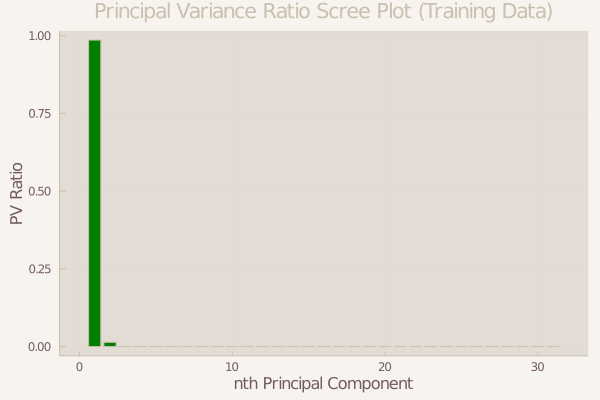

In [10]:
println("---------------------------------------------------------------------------------------")
println("PCA Analysis with All Principal Components (Training Data)")
println()

# transposing X to fit orientation for MultivariateStats.fit function
X_tp_train = Transpose(X_train)
println("X_tp_train type: " * string(typeof(X_tp_train)))
println("X_tp_train size: " * string(size(X_tp_train)))
println("X_tp_train head:")
show(stdout, "text/plain", X_tp_train[:, 1:10])
println()
    
# Computing all principal components
M_full_train = fit(PCA, X_tp_train; pratio = 1.00)
println("M_full_train: " * string(M_full_train))
println("M_full_train type: " * string(typeof(M_full_train)))
println("input dimension d: " * string(indim(M_full_train)))
println("output dimension p: " * string(outdim(M_full_train)))
println()

# transformed data from Transposed X using all principal components
X_tr_full_train = transform(M_full_train, X_tp_train)
println("X_tr_full_train type: " * string(typeof(X_tr_full_train)))
println("X_tr_full_train size: " * string(size(X_tr_full_train)))
println("X_tr_full_train head:")
show(stdout, "text/plain", X_tr_full_train[:, 1:10])
println()

# projection matrix for all components included
proj_full_train = projection(M_full_train)
println("proj_full_train type: " * string(typeof(proj_full_train)))
println("proj_full_train size: " * string(size(proj_full_train)))
show(stdout, "text/plain", proj_full_train)
println()

pvs_train = principalvars(M_full_train)
println("Principal Variances (pvs_train):")
show(stdout, "text/plain", pvs_train)
println()

pvr_arr_train = principalvars(M_full_train) ./ tvar(M_full_train)
println("Principal Variance Ratios (pvr_arr_train):")
show(stdout, "text/plain", pvr_arr_train)
println()

pvr_train = principalratio(M_full_train)
println("Principal Ratio (pvr_train): " * string(pvr_train))
println()

println("---------------------------------------------------------------------------------------")
println("Principal Variance Ratio Scree Plot")
println()

theme(:sand)

bar(pvr_arr_train,
    title = "Principal Variance Ratio Scree Plot (Training Data)",
    xlabel = "nth Principal Component",
    ylabel = "PV Ratio",
    palette = :ocean,
    legend = false)


---------------------------------------------------------------------------------------
PCA Analysis with All Principal Components (Testing Data)

X_tp_test type: Transpose{Float64,Array{Float64,2}}
X_tp_test size: (31, 2558)
X_tp_test head:
31×10 Array{Float64,2}:
   75.3876      61.046       53.3941      61.2734      61.8831      62.9817      66.1859      59.0385      83.2305      53.7326
    1.7797       1.57063      1.66664      1.52356      1.60109      1.58898      1.67586      1.60759      1.72229      1.36304
    5.0          4.0          7.0          4.0          4.0          4.0          7.0          6.0          5.0          3.0
    5.0          8.0          3.0          7.0          8.0          5.0          9.0          6.0          5.0          5.0
    6.0          6.0          5.0          7.0          8.0          5.0          7.0          7.0          6.0          4.0
    5.0          5.0          2.0          9.0          1.0          1.0          7.0          8.0    

 -4.88985e-5   -0.000509663  -0.0140712     0.0127359    -0.000921813   0.0104287     0.284646      0.0632006     0.0460897   -0.104407     -0.0953644     0.00542692    0.899929      0.265527     0.0174056     0.0978637    0.0254791    -0.0240448    -0.0146836   -0.00159945   -0.00580295   -0.00984803    0.010113      0.0136327    -0.0135616    -0.00233068   -0.0073056     7.57905e-13  -6.68721e-16   3.28163e-14  -5.74551e-12
 -0.000116742  -0.00115265   -0.00602233   -0.00141146   -0.0092867     0.126315      0.0174062     0.00559996    0.125827     0.0289286    -0.687516      0.640244     -0.133539      0.208412     0.0314383    -0.13505     -0.00125952    0.0151488     0.020765    -0.0143548     0.0447054    -0.0250106    -0.0141429    -0.0112164     0.000590269   0.00312981    0.00153159    6.41952e-13   1.40779e-15  -4.55476e-14   7.98495e-12
 -1.91926e-5    6.53574e-5   -0.0125953     0.0306382    -0.0256062     0.171192      0.0161284    -0.00317844    0.204991     0.0576547    

  1.63954e-7   -0.000165782   0.0202161     0.00378188   -0.0121178     0.00207246    0.00555148   -0.00331393    0.00710556  -0.0123944    -0.00820589    0.00322484    0.00730985   -0.0193423    0.199421      0.145515    -0.173089      0.622479     -0.0733104   -0.112205     -0.100258      0.0493119    -0.389076     -0.0109437     0.00690409    0.0222617     0.0668323    -6.59863e-5   -0.562626      0.12955       0.00151037
 -8.5364e-6     8.78854e-5   -0.0184872    -0.00236368    0.0083027    -0.00306629   -0.00098823   -0.00153794   -0.00318574   0.0149973     0.00706898   -0.00734378   -0.00419106    0.0170248   -0.109449     -0.0502627    0.0734645    -0.00716794   -0.216107     0.335686      0.416369     -0.0448797     0.549085     -0.018938      0.00288687   -0.028553     -0.0905333    -6.59863e-5   -0.562626      0.12955       0.00151037
 -1.05334e-5   -0.000103347   0.00363057    4.99011e-5    0.00107282    0.00203749    0.00883427    0.000144998   0.00276051   0.00932169   -0

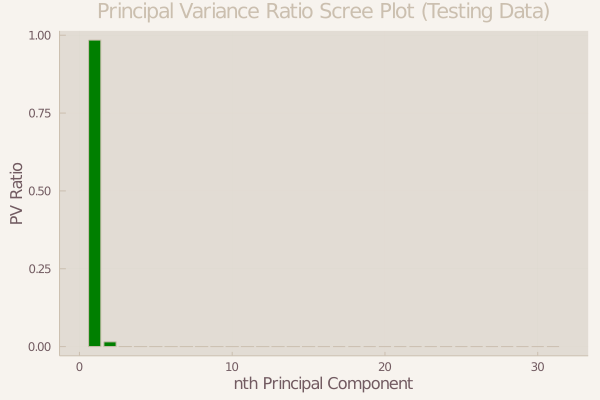

In [13]:
println("---------------------------------------------------------------------------------------")
println("PCA Analysis with All Principal Components (Testing Data)")
println()

# transposing X to fit orientation for MultivariateStats.fit function
X_tp_test = transpose(X_test)
println("X_tp_test type: " * string(typeof(X_tp_test)))
println("X_tp_test size: " * string(size(X_tp_test)))
println("X_tp_test head:")
show(stdout, "text/plain", X_tp_test[:, 1:10])
println()
    
# Computing all principal components
M_full_test = fit(PCA, X_tp_test; pratio = 1.00)
println("M_full_test: " * string(M_full_test))
println("M_full_test type: " * string(typeof(M_full_test)))
println("input dimension d: " * string(indim(M_full_test)))
println("output dimension p: " * string(outdim(M_full_test)))
println()

# transformed data from transposed X using all principal components
X_tr_full_test = transform(M_full_test, X_tp_test)
println("X_tr_full_test type: " * string(typeof(X_tr_full_test)))
println("X_tr_full_test size: " * string(size(X_tr_full_test)))
println("X_tr_full_test head:")
show(stdout, "text/plain", X_tr_full_test[:, 1:10])
println()

# projection matrix for all components included
proj_full_test = projection(M_full_test)
println("proj_full_test type: " * string(typeof(proj_full_test)))
println("proj_full_test size: " * string(size(proj_full_test)))
show(stdout, "text/plain", proj_full_test)
println()

pvs_test = principalvars(M_full_test)
println("Principal Variances (pvs_test):")
show(stdout, "text/plain", pvs_test)
println()

pvr_arr_test = principalvars(M_full_test) ./ tvar(M_full_test)
println("Principal Variance Ratios (pvr_arr_test):")
show(stdout, "text/plain", pvr_arr_test)
println()

pvr_test = principalratio(M_full_test)
println("Principal Ratio (pvr_test): " * string(pvr_test))
println()

println("---------------------------------------------------------------------------------------")
println("Principal Variance Ratio Scree Plot")
println()

theme(:sand)

bar(pvr_arr_test,
    title = "Principal Variance Ratio Scree Plot (Testing Data)",
    xlabel = "nth Principal Component",
    ylabel = "PV Ratio",
    palette = :ocean,
    legend = false)


Testing misclassification rate against number of principal components (highest to lowest variance)



PCA uses default pratio to compute number of principal components to keep

In [11]:
using Statistics

In [14]:
println("---------------------------------------------------------------------------------------")
println("Preparing transformed training data for classifier")
println()

# best number of principal components for training data determined by default (99% of total variance)
M_train = fit(PCA, X_tp_train)
X_tr_train = transform(M_train, X_tp_train)
println("X_tr_train type: " * string(typeof(X_tr_train)))
println("X_tr_train size: " * string(size(X_tr_train)))
println("X_tr_train head:")
show(stdout, "text/plain", X_tr_train[:, 1:10])
println()

# correctly orient X training set for ScikitLearn classifiers
X_fit_train = Transpose(X_tr_train)
println("X_fit_train type: " * string(typeof(X_fit_train)))
println("X_fit_train size: " * string(size(X_fit_train)))
println("X_fit_train head:")
show(stdout, "text/plain", X_fit_train[1:10, :])
println()

println("---------------------------------------------------------------------------------------")
println("Preparing transformed testing data for classifier")
println()

# best number of principal components for testing data determined by default (99% of total variance)
M_test = fit(PCA, X_tp_test)
X_tr_test = transform(M_test, X_tp_test)
println("X_tr_test type: " * string(typeof(X_tr_test)))
println("X_tr_test size: " * string(size(X_tr_test)))
println("X_tr_test head:")
show(stdout, "text/plain", X_tr_test[:, 1:10])
println()

# correctly orient X testing set for ScikitLearn classifiers
X_fit_test = Transpose(X_tr_test)
println("X_fit_test type: " * string(typeof(X_fit_test)))
println("X_fit_test size: " * string(size(X_fit_test)))
println("X_fit_test head:")
show(stdout, "text/plain", X_fit_test[1:10, :])
println()


---------------------------------------------------------------------------------------
Preparing transformed training data for classifier

X_tr_train type: Array{Float64,2}
X_tr_train size: (2, 5967)
X_tr_train head:
2×10 Array{Float64,2}:
 309.101  -823.398  309.21   -237.295    8.19803   211.416  179.621   2442.64  -1429.2     -757.41
 125.706   150.722  124.726  -116.808  -43.6278   -191.46   -29.7157  -150.96     17.7061  -139.429
X_fit_train type: Transpose{Float64,Array{Float64,2}}
X_fit_train size: (5967, 2)
X_fit_train head:
10×2 Array{Float64,2}:
   309.101     125.706
  -823.398     150.722
   309.21      124.726
  -237.295    -116.808
     8.19803   -43.6278
   211.416    -191.46
   179.621     -29.7157
  2442.64     -150.96
 -1429.2        17.7061
  -757.41     -139.429
---------------------------------------------------------------------------------------
Preparing transformed testing data for classifier

X_tr_test type: Array{Float64,2}
X_tr_test size: (2, 2558)
X_tr_tes

In [16]:
@sk_import svm: SVC

svc_model = SVC()
# svc_model.fit(X_fit_train, y_train)
# println(svc_model)

# svc_score = svc_model.score(X_fit_test, y_test)
# println("svc_score: " * string(svc_score))


PyObject SVC()

In [ ]:

svc_score_arr = Array{Float64, 1}()

Threads.@threads for n in tqdm(1:27)
    println("number of principal components (n): " * string(n))

    X_tr_train = X_tr_full_train[1:n, :]
#     println("X_tr_train type: " * string(typeof(X_tr_train)))
#     println("X_tr_train size: " * string(size(X_tr_train)))
#     println("X_tr_train head:")
#     show(stdout, "text/plain", X_tr_train[:, 1:10])
#     println()

    # correctly orient X training set for ScikitLearn classifiers
    X_fit_train = Transpose(X_tr_train)
#     println("X_fit_train type: " * string(typeof(X_fit_train)))
#     println("X_fit_train size: " * string(size(X_fit_train)))
#     println("X_fit_train head:")
#     show(stdout, "text/plain", X_fit_train[1:10, :])
#     println()



    X_tr_test = X_tr_full_test[1:n, :]
#     println("X_tr_test type: " * string(typeof(X_tr_test)))
#     println("X_tr_test size: " * string(size(X_tr_test)))
#     println("X_tr_test head:")
#     show(stdout, "text/plain", X_tr_test[:, 1:10])
#     println()

    # correctly orient X testing set for ScikitLearn classifiers
    X_fit_test = Transpose(X_tr_test)
#     println("X_fit_test type: " * string(typeof(X_fit_test)))
#     println("X_fit_test size: " * string(size(X_fit_test)))
#     println("X_fit_test head:")
#     show(stdout, "text/plain", X_fit_test[1:10, :])
#     println()
    
    svc_model.fit(X_fit_train, y_train)
    println(svc_model)

    svc_score = svc_model.score(X_fit_test, y_test)
    push!(svc_score)
    println("svc_score: " * string(svc_score))

end
